## 2. Paper plots

Plots for super-greenhouse climatology paper (Dewey, Abraham, and Goldblatt 2024) \
Data required for plotting is available via project repository. 

Maura Dewey (maura.dewey@misu.su.se), 2023 

In [35]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec
import seaborn as sns 
import cartopy
from statsmodels.tsa.seasonal import STL
import cmasher as cm
from scipy import stats
import scipy
import textwrap
from SGE_utils import *

In [2]:
SGE_ts = xr.open_dataset('SGE_timeseries_2002_2023_v6.nc').sel(time=slice('2003-01-01','2022-12-31'))

In [3]:
def lat_weighted_mean(x):
    weights = np.cos(np.deg2rad(x.lat))
    return x.weighted(weights).mean(['lat', 'lon'])

In [19]:
SGE_ts

<xarray.Dataset>
Dimensions:        (time: 7305, lon: 360, lat: 70)
Coordinates:
  * time           (time) datetime64[ns] 2003-01-01 2003-01-02 ... 2022-12-31
  * lon            (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat            (lat) float32 -34.5 -33.5 -32.5 -31.5 ... 31.5 32.5 33.5 34.5
Data variables: (12/15)
    SGE_occ_all    (time, lat, lon) float32 ...
    SGE_occ_clr    (time, lat, lon) float32 ...
    SGE_str_all    (time, lat, lon) float32 nan nan nan 0.0 ... nan nan nan nan
    SGE_str_clr    (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    SGE_frac_all   (time) float64 ...
    SGE_frac_clr   (time) float64 0.006619 0.005109 ... 0.006106 0.00577
    ...             ...
    SGE_pw_clr     (time) float64 ...
    clr_flag       (time, lat, lon) float32 ...
    all_flag       (time, lat, lon) float32 ...
    airs_flag      (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    landmask       (lat, lon) float32 ...
    sst            (time, lat, lon) float32 ...

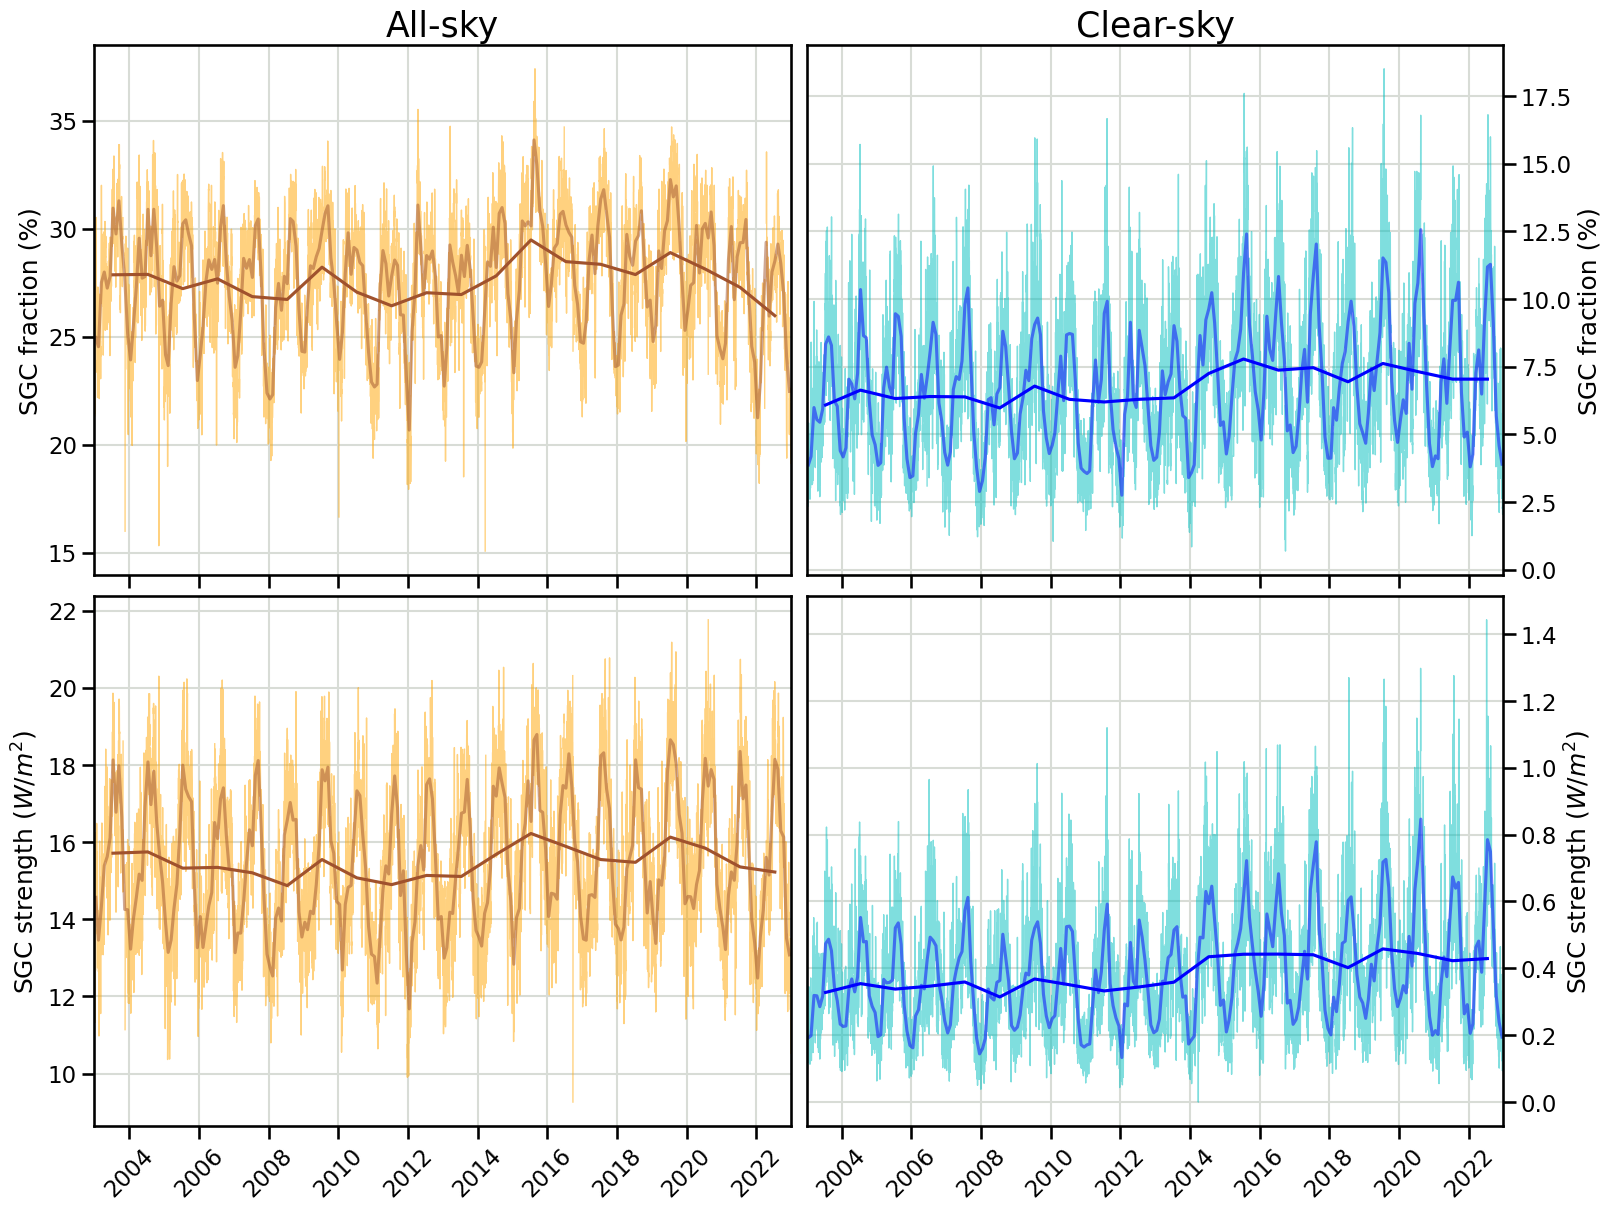

In [18]:
#Figure 1, timeseries trends. 
# Clear-sky and all-sky area fraction of tropical oceans in SGC [%], and mean tropical SGC strength [W/m^2].

frc_all = SGE_ts.SGE_frac_all2*100
frc_all_na = frc_all.where(SGE_ts['airs_flag']==0) #remove days without AIRS measurements from all-sky data (79 days total)
frc_all_clean = frc_all_na.where(frc_all_na>15)
frc_all_mm = frc_all_clean.resample(time='M', skipna=True).mean()
frc_all_ann = frc_all_clean.resample(time='Y', skipna=True).mean()

frc_clr = SGE_ts.SGE_frac_clr2*100 #frc"2" is fraction of SGE divided by total area with observed clear-sky OLR
frc_clr_clean = frc_clr.where(frc_clr>0)
frc_clr_mm = frc_clr_clean.resample(time='M', skipna=True).mean()
frc_clr_ann = frc_clr_clean.resample(time='Y', skipna=True).mean()

str_all = lat_weighted_mean(SGE_ts.SGE_str_all)
str_all_clean = str_all.where(SGE_ts['airs_flag']==0) #remove days without AIRS measurements from all-sky data (79 days total)
str_all_clean = str_all_clean.where(str_all_clean>9)
str_all_mm = str_all_clean.resample(time='M', skipna=True).mean()
str_all_ann = str_all_clean.resample(time='Y', skipna=True).mean()

str_clr = lat_weighted_mean(SGE_ts.SGE_str_clr)
str_clr_mm = str_clr.resample(time='M', skipna=True).mean()
str_clr_ann = str_clr.resample(time='Y', skipna=True).mean()

with sns.plotting_context("talk"):

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,12), sharex=True, sharey=False, constrained_layout=True)
    axes[0,0].plot(pd.to_datetime(frc_all_clean['time']), frc_all_clean, color='orange',linewidth=1,alpha=0.5)
    axes[0,0].plot(pd.to_datetime(frc_all_mm['time'])- pd.Timedelta(15, 'D'), frc_all_mm, color='sienna',alpha=0.5)
    axes[0,0].plot(pd.to_datetime(frc_all_ann['time'])- pd.Timedelta(169, 'D'), frc_all_ann, color='sienna')
    axes[0,0].autoscale(enable=True, axis='x', tight=True)
    axes[0,0].set_title('All-sky', fontsize=25)
    axes[0,0].set_ylabel('SGC fraction (%)')
    axes[0,0].grid(color='xkcd:light grey')
    
    axes[0,1].plot(pd.to_datetime(frc_clr_clean['time']), frc_clr_clean, linewidth=1,color='c',alpha=0.5)
    axes[0,1].plot(pd.to_datetime(frc_clr_mm['time'])- pd.Timedelta(15, 'D'), frc_clr_mm, color='b',alpha=0.5)
    axes[0,1].plot(pd.to_datetime(frc_clr_ann['time'])- pd.Timedelta(169, 'D'), frc_clr_ann, color='b')
    axes[0,1].set_title('Clear-sky', fontsize=25)
    axes[0,1].autoscale(enable=True, axis='x', tight=True)
    axes[0,1].yaxis.tick_right()
    axes[0,1].yaxis.set_label_position("right")
    axes[0,1].set_ylabel('SGC fraction (%)')
    axes[0,1].grid(color='xkcd:light grey')

    axes[1,0].plot(pd.to_datetime(str_all_clean['time']), str_all_clean, color='orange',linewidth=1,alpha=0.5)
    axes[1,0].plot(pd.to_datetime(str_all_mm['time'])- pd.Timedelta(15, 'D'), str_all_mm, color='sienna',alpha=0.5)
    axes[1,0].plot(pd.to_datetime(str_all_ann['time'])- pd.Timedelta(169, 'D'), str_all_ann, color='sienna')
    axes[1,0].autoscale(enable=True, axis='x', tight=True)
    axes[1,0].set_ylabel('SGC strength ($W/m^2$)')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].grid(color='xkcd:light grey')

    axes[1,1].plot(pd.to_datetime(str_clr['time']), str_clr, linewidth=1,color='c',alpha=0.5)
    axes[1,1].plot(pd.to_datetime(str_clr_mm['time'])- pd.Timedelta(15, 'D'), str_clr_mm,  color='b',alpha=0.5)
    axes[1,1].plot(pd.to_datetime(str_clr_ann['time'])- pd.Timedelta(169, 'D'), str_clr_ann, color='b')
    axes[1,1].autoscale(enable=True, axis='x', tight=True)
    axes[1,1].yaxis.tick_right()
    axes[1,1].yaxis.set_label_position("right")
    axes[1,1].set_ylabel('SGC strength ($W/m^2$)')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].grid(color='xkcd:light grey')

In [13]:
#Figure 2: Annual cycles with monthly means

df_pwALLmm = str_all_clean.resample(time='M', skipna=True).mean().to_dataframe()
df_pwALLmm['year'] = df_pwALLmm.index.year
df_pwALLmm['month'] = df_pwALLmm.index.month
df_frALLmm = frc_all_clean.resample(time='M', skipna=True).mean().to_dataframe()
df_ALLmm = pd.concat([df_pwALLmm, df_frALLmm], axis=1)

df_pwCLRmm = str_clr.resample(time='M', skipna=True).mean().to_dataframe()
df_pwCLRmm['year'] = df_pwCLRmm.index.year
df_pwCLRmm['month'] = df_pwCLRmm.index.month
df_frCLRmm = frc_clr_clean.resample(time='M', skipna=True).mean().to_dataframe()
df_CLRmm = pd.concat([df_pwCLRmm, df_frCLRmm], axis=1)

Text(0, 0.5, 'cler-sky SGC fraction')

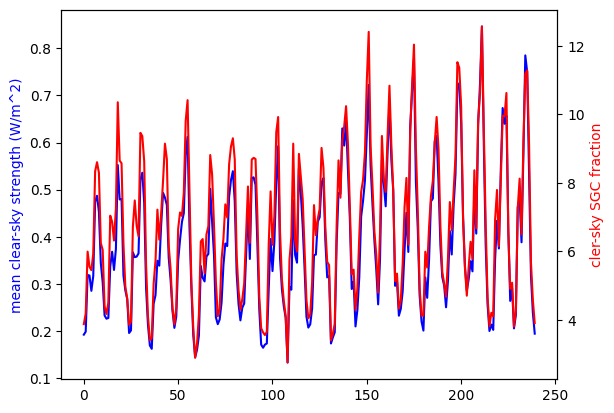

In [27]:
fig, ax1 = plt.subplots()
ax1.plot(lat_weighted_mean(SGE_ts.SGE_occ_clr*SGE_ts.SGE_str_clr).resample(time='M', skipna=True).mean(), color='b')
ax1.set_ylabel('mean clear-sky strength (W/m^2)', color='b')
ax2=ax1.twinx()
ax2.plot(frc_clr_mm.resample(time='M', skipna=True).mean(), color='r')
ax2.set_ylabel('cler-sky SGC fraction', color='r')

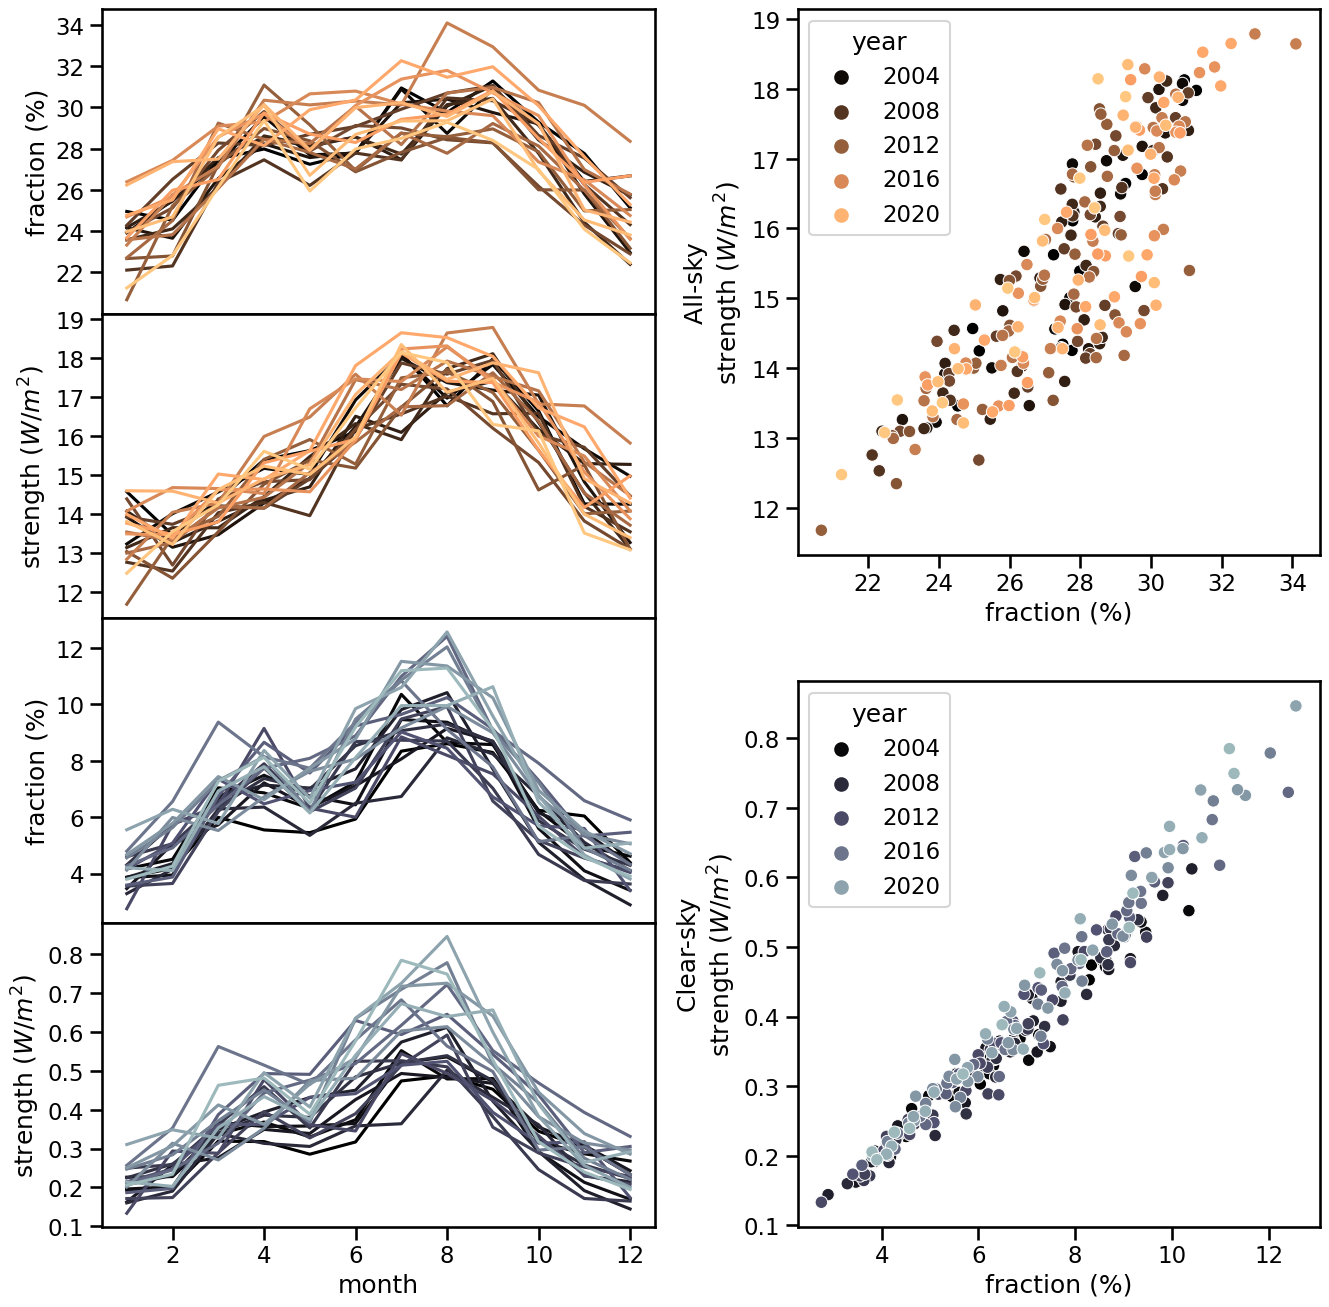

In [7]:
#Figure 2:

with sns.plotting_context("talk"):
 
    fig = plt.figure(figsize=(14,14))
    gs_left = gridspec.GridSpec(ncols=4, nrows=4, hspace = 0.0, wspace = 0.5)
    gs_right = gridspec.GridSpec(ncols=4, nrows=4, hspace=0.6, wspace=1)
    fig.subplots_adjust(left=0.08, right=0.95, bottom=0.08, top=0.95)

    ax1 = fig.add_subplot(gs_left[0,0:2])
    sns.lineplot(ax=ax1,data=df_ALLmm, x='month',y='SGE_frac_all2',hue='year',palette='copper',legend=False)
    ax1.set_ylabel('fraction (%)')

    ax2 = fig.add_subplot(gs_left[1,0:2])
    sns.lineplot(ax=ax2,data=df_ALLmm, x='month',y='SGE_str_all',hue='year',palette='copper',legend=False)
    ax2.set_ylabel('strength ($W/m^2$)')

    ax3 = fig.add_subplot(gs_left[2,0:2])
    sns.lineplot(data=df_CLRmm, x='month',y='SGE_frac_clr2',hue='year',palette=cm.get_sub_cmap('bone', 0.0, 0.7),legend=False)
    ax3.set_ylabel('fraction (%)')

    ax4 = fig.add_subplot(gs_left[3,0:2])
    sns.lineplot(data=df_CLRmm, x='month',y='SGE_str_clr',hue='year',palette=cm.get_sub_cmap('bone', 0.0, 0.7),legend=False)
    ax4.set_ylabel('strength ($W/m^2$)')

    ax5 = fig.add_subplot(gs_right[0:2,2:4])
    sns.scatterplot(ax=ax5,data=df_ALLmm,x='SGE_frac_all2',y='SGE_str_all',hue='year',palette='copper')
    #sns.regplot(ax=ax5,data=df_ALL,x='SGE_frac_all',y='SGE_pw_all',scatter=False,color='orange',ci=None,robust=True)
    ax5.set_ylabel(' All-sky \nstrength ($W/m^2$)')
    ax5.set_xlabel('fraction (%)')

    ax6 = fig.add_subplot(gs_right[2:4,2:4])
    sns.scatterplot(ax=ax6,data=df_CLRmm,x='SGE_frac_clr2',y='SGE_str_clr',hue='year',palette=cm.get_sub_cmap('bone', 0.0, 0.7))
    #sns.regplot(ax=ax6,data=df_CLR,x='SGE_frac_clr',y='SGE_pw_clr',scatter=False,color='skyblue',ci=None,robust=True)
    ax6.set_ylabel(' Clear-sky \nstrength ($W/m^2$)')
    ax6.set_xlabel('fraction (%)')

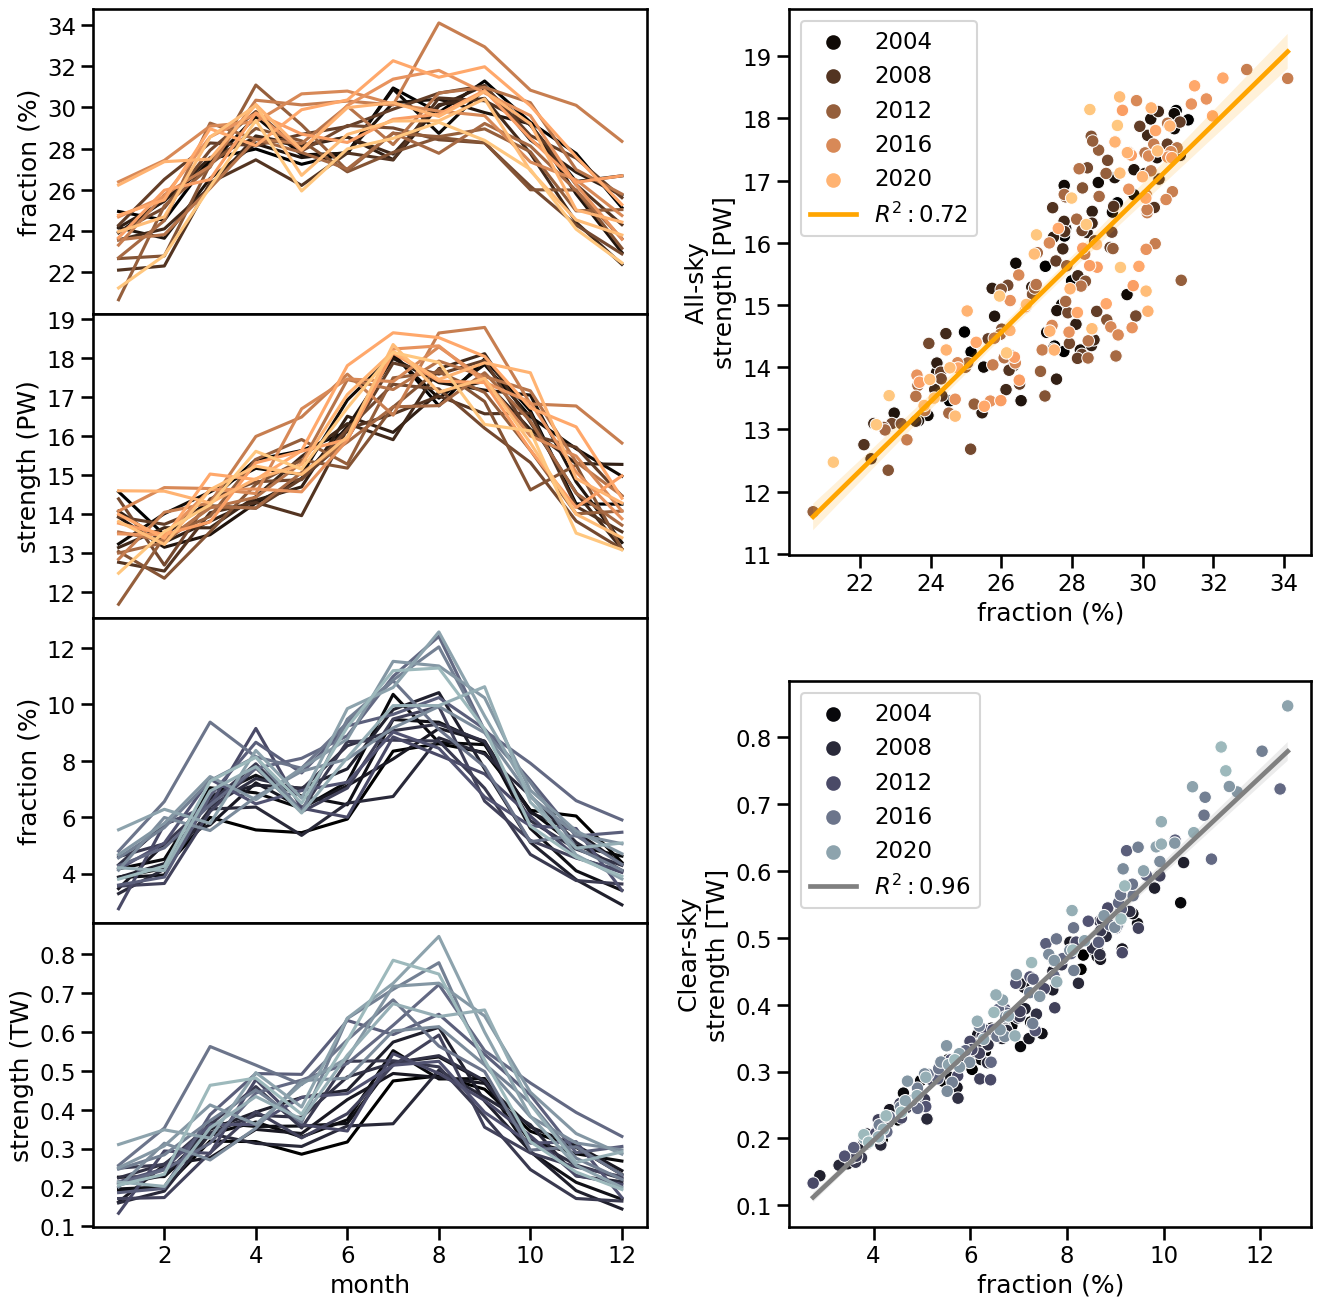

In [10]:
#Figure 2 with linear correlation coefficients:

with sns.plotting_context("talk"):
 
    fig = plt.figure(figsize=(14,14))
    gs_left = gridspec.GridSpec(ncols=4, nrows=4, hspace = 0.0, wspace = 0.5)
    gs_right = gridspec.GridSpec(ncols=4, nrows=4, hspace=0.6, wspace=1)
    fig.subplots_adjust(left=0.08, right=0.95, bottom=0.08, top=0.95)

    ax1 = fig.add_subplot(gs_left[0,0:2])
    sns.lineplot(ax=ax1,data=df_ALLmm, x='month',y='SGE_frac_all2',hue='year',palette='copper',legend=False)
    ax1.set_ylabel('fraction (%)')

    ax2 = fig.add_subplot(gs_left[1,0:2])
    sns.lineplot(ax=ax2,data=df_ALLmm, x='month',y='SGE_str_all',hue='year',palette='copper',legend=False)
    ax2.set_ylabel('strength (PW)')

    ax3 = fig.add_subplot(gs_left[2,0:2])
    sns.lineplot(data=df_CLRmm, x='month',y='SGE_frac_clr2',hue='year',palette=cm.get_sub_cmap('bone', 0.0, 0.7),legend=False)
    ax3.set_ylabel('fraction (%)')

    ax4 = fig.add_subplot(gs_left[3,0:2])
    sns.lineplot(data=df_CLRmm, x='month',y='SGE_str_clr',hue='year',palette=cm.get_sub_cmap('bone', 0.0, 0.7),legend=False)
    ax4.set_ylabel('strength (TW)')

    ax5 = fig.add_subplot(gs_right[0:2,2:4])
    sns.scatterplot(ax=ax5,data=df_ALLmm,x='SGE_frac_all2',y='SGE_str_all',hue='year',palette='copper')
    slope, intcpt, r_value1, p_value, stderr = stats.linregress(df_ALLmm['SGE_frac_all2'],df_ALLmm['SGE_str_all'])
    label1 = r'$R^2:{0:.2f}$'.format(r_value1**2)
    sns.regplot(ax=ax5,data=df_ALLmm,x='SGE_frac_all2',y='SGE_str_all',scatter=False,line_kws={'color':'orange'},ci=95,label=label1)
    ax5.legend()
    ax5.set_ylabel(' All-sky \nstrength [PW]')
    ax5.set_xlabel('fraction (%)')

    ax6 = fig.add_subplot(gs_right[2:4,2:4])
    sns.scatterplot(ax=ax6,data=df_CLRmm,x='SGE_frac_clr2',y='SGE_str_clr',hue='year',palette=cm.get_sub_cmap('bone', 0.0, 0.7))
    slope, intcpt, r_value2, p_value, stderr = stats.linregress(df_CLRmm['SGE_frac_clr2'],df_CLRmm['SGE_str_clr'])
    label2 = r'$R^2:{0:.2f}$'.format(r_value2**2)
    sns.regplot(ax=ax6,data=df_CLRmm,x='SGE_frac_clr2',y='SGE_str_clr',scatter=False,line_kws={'color':'grey'},ci=95,label=label2)
    ax6.legend()
    ax6.set_ylabel(' Clear-sky \nstrength [TW]')
    ax6.set_xlabel('fraction (%)')

In [42]:
# Calculate fraction of measured area in SGC, for each hemisphere seperately:

#calculate fraction of tropics area in SGE (ocean area between 35N/S)
mask = xr.open_dataset('/home/mdewey/Data/CERES_SSF1deg-Day_Aqua-MODIS_Ed4.1_Subset_20220101-20221231.nc')['aux_ocean_daily'][0,:,:]
landmask = mask.where(mask==100,0)/100
xlon, ylat = np.meshgrid(SGE_ts.SGE_str_all.lon, SGE_ts.SGE_str_all.lat)
R = earth_radius(ylat)
dlat = np.deg2rad(np.gradient(ylat, axis=0))
dlon = np.deg2rad(np.gradient(xlon, axis=1))
dy = dlat * R
dx = dlon * R * np.cos(np.deg2rad(ylat))
area_grid = dy * dx * landmask

SGE_area_all = SGE_ts.SGE_occ_all*area_grid
SGE_area_clr = SGE_ts.SGE_occ_clr*area_grid

clr_area_NH = (SGE_ts.clr_flag*area_grid).sel(lat=slice(0,35)).sum(dim=['lat','lon']) #total clear-sky measured area in NH
clr_area_SH = (SGE_ts.clr_flag*area_grid).sel(lat=slice(-35,0)).sum(dim=['lat','lon'])
all_area_NH = (SGE_ts.all_flag*area_grid).sel(lat=slice(0,35)).sum(dim=['lat','lon'])
all_area_SH = (SGE_ts.all_flag*area_grid).sel(lat=slice(-35,0)).sum(dim=['lat','lon'])

SGE_frac_clr2_NH = (SGE_area_clr.sel(lat=slice(0,35)).sum(dim=['lat','lon'])/clr_area_NH)*100 #total clear-sky SGC area in NH / total measured area in NH
SGE_frac_clr2_SH = (SGE_area_clr.sel(lat=slice(-35,0)).sum(dim=['lat','lon'])/clr_area_SH)*100
SGE_frac_all2_NH = (SGE_area_all.sel(lat=slice(0,35)).sum(dim=['lat','lon'])/all_area_NH)*100 #total all-sky SGC area in NH / total measured area in NH
SGE_frac_all2_SH = (SGE_area_all.sel(lat=slice(-35,0)).sum(dim=['lat','lon'])/all_area_SH)*100

#clean up all-sky fraction:
SGE_frac_all2_NH = SGE_frac_all2_NH.where(SGE_ts['airs_flag']==0) #remove days without AIRS measurements from all-sky data (79 days total)
SGE_frac_all2_SH = SGE_frac_all2_SH.where(SGE_ts['airs_flag']==0)

#take monthly means:
SGE_frac_clr2_NH_mm = SGE_frac_clr2_NH.resample(time='M', skipna=True).mean()
SGE_frac_clr2_SH_mm = SGE_frac_clr2_SH.resample(time='M', skipna=True).mean()
SGE_frac_all2_NH_mm = SGE_frac_all2_NH.resample(time='M', skipna=True).mean()
SGE_frac_all2_SH_mm = SGE_frac_all2_SH.resample(time='M', skipna=True).mean()


Text(0, 0.5, 'NH SST')

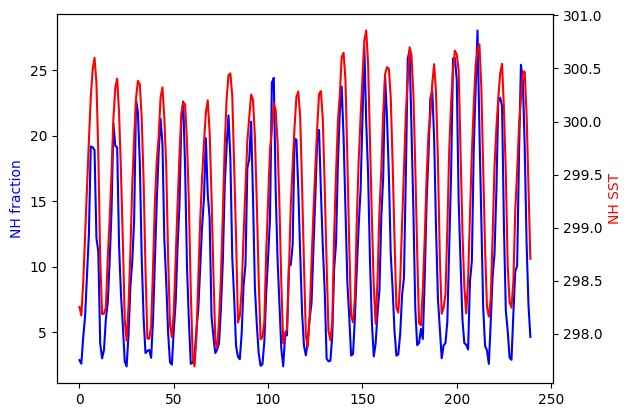

In [58]:
fig, ax1 = plt.subplots()
ax1.plot(SGE_frac_clr2_NH_mm, color='b')
ax1.set_ylabel('NH fraction', color='b')
ax2=ax1.twinx()
ax2.plot(sst_NH_mm, color='r')
ax2.set_ylabel('NH SST', color='r')



Text(0, 0.5, 'NH SST')

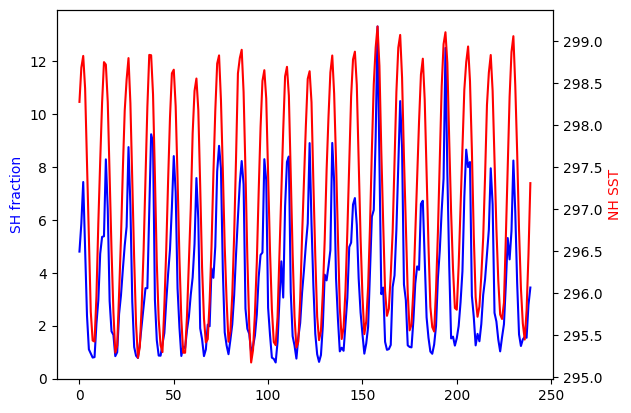

In [59]:
fig, ax1 = plt.subplots()
ax1.plot(SGE_frac_clr2_SH_mm, color='b')
ax1.set_ylabel('SH fraction', color='b')
ax2=ax1.twinx()
ax2.plot(sst_SH_mm, color='r')
ax2.set_ylabel('SH SST', color='r')

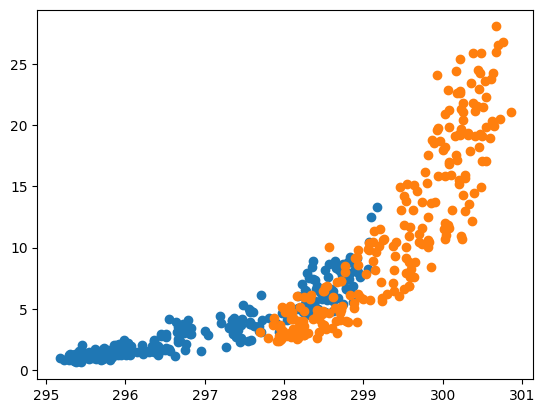

In [67]:
fig, ax = plt.subplots()
plt.scatter(sst_SH_mm, SGE_frac_clr2_SH_mm)
plt.scatter(sst_NH_mm, SGE_frac_clr2_NH_mm)

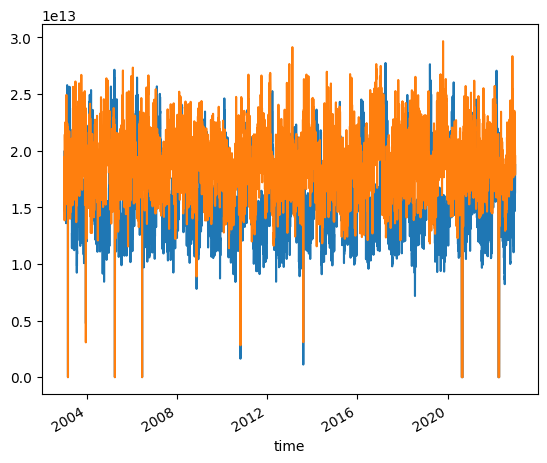

In [49]:
clr_area_NH.plot()
clr_area_SH.plot()

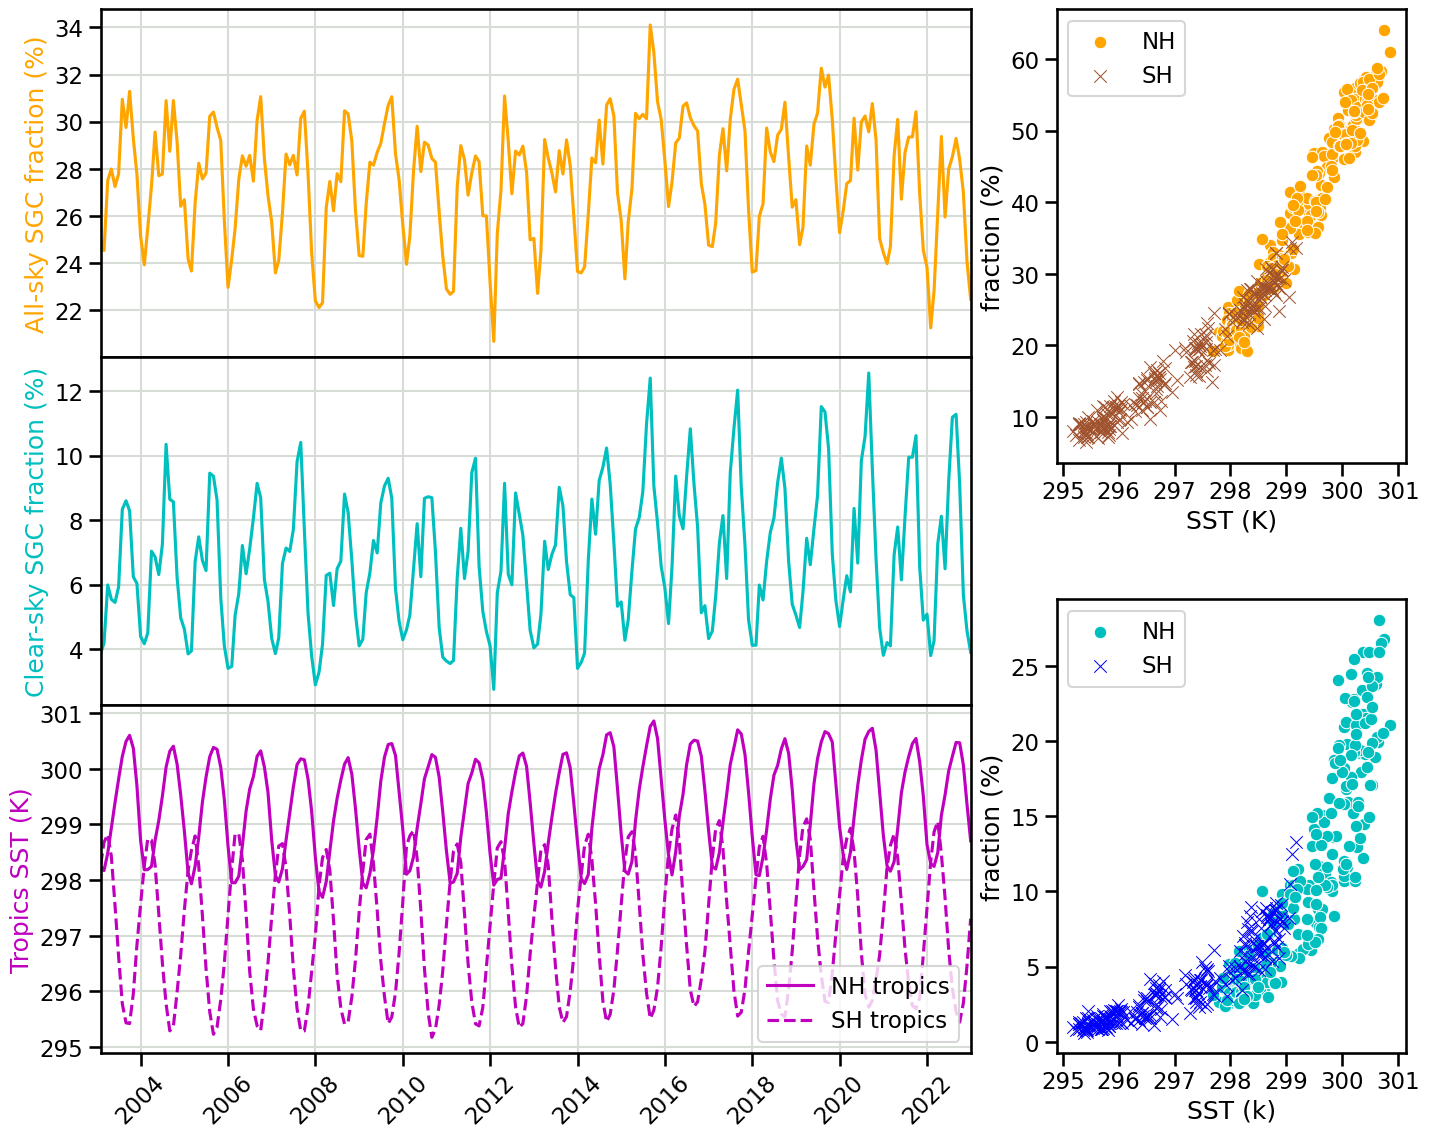

In [73]:
##Figure 3, time-series of SGC fraction with tropical SSTs with additional correlation column:
import matplotlib.ticker as ticker

sst_mm = lat_weighted_mean(SGE_ts.sst).resample(time='M', skipna=True).mean().sel(time=slice('2003', '2022')) 
sst_SH_mm = lat_weighted_mean(SGE_ts.sst.sel(lat=slice(-35,0))).resample(time='M', skipna=True).mean().sel(time=slice('2003', '2022')) 
sst_NH_mm = lat_weighted_mean(SGE_ts.sst.sel(lat=slice(0,35))).resample(time='M', skipna=True).mean().sel(time=slice('2003', '2022')) 

d1 = {'frc_clr_NH': SGE_frac_clr2_NH_mm, 'frc_clr_SH': SGE_frac_clr2_SH_mm, 'frc_all_NH': SGE_frac_all2_NH_mm, 'frc_all_SH': SGE_frac_all2_SH_mm, 'sst_NH_mm': sst_NH_mm, 'sst_SH_mm': sst_SH_mm, 'time_all': frc_all_mm['time'], 'time_clr': frc_clr_mm['time']}
df_scatterplt = pd.DataFrame(data=d1)

with plt.rc_context({'axes.autolimit_mode': 'round_numbers'}) and sns.plotting_context('talk'):
    fig = plt.figure(figsize=(15,12))
    gs_left = gridspec.GridSpec(ncols=3, nrows=3, hspace = 0.0, wspace = 0.0)
    gs_right = gridspec.GridSpec(ncols=3, nrows=2, hspace=0.3, wspace=0.37)
    fig.subplots_adjust(left=0.08, right=0.95, bottom=0.08, top=0.95)

    ax1 = fig.add_subplot(gs_left[0,0:2])
    ax1.plot(frc_all_mm['time'], frc_all_mm, color='orange')
    ax1.grid(color='xkcd:light grey')
    #ax2 = ax1.twinx()
    #ax2.plot(sst_SH_mm['time'], sst_SH_mm, color='orange',linestyle='--')
    #ax2.plot(sst_NH_mm['time'], sst_NH_mm, color='orange')
    #ax2.plot(sst_al_mm['time'], sst_al_mm-sst_al_mm.mean(), color='red')
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_ylabel('All-sky SGC fraction (%)', color='orange')
    #ax2.set_ylabel('Tropics SST (K)', color='orange')
    ax1.autoscale(enable=True, axis='x', tight=True)
    plt.setp(ax1.get_xticklabels(), visible=False)
    #plt.legend(['SH tropics','NH tropics'])

    ax3 = fig.add_subplot(gs_right[0,2])
    sns.scatterplot(ax=ax3,data=df_scatterplt,y='frc_all_NH',x='sst_NH_mm',color='orange',label='NH')
    sns.scatterplot(ax=ax3,data=df_scatterplt,y='frc_all_SH',x='sst_SH_mm',color='sienna',marker='x',label='SH')
    ax3.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    plt.legend(loc='upper left')
    #plt.setp(ax3.get_yticklabels(), visible=False)
    plt.ylabel('fraction (%)')
    plt.xlabel('SST (K)')

    ax4 = fig.add_subplot(gs_left[1,0:2])
    ax4.plot(frc_clr_mm['time'], frc_clr_mm, color='c')
    ax4.grid(color='xkcd:light grey')
    #ax5 = ax4.twinx()
    #ax5.plot(sst_SH_mm['time'], sst_SH_mm, color='c',linestyle='--')
    #ax5.plot(sst_NH_mm['time'], sst_NH_mm, color='c')
    #ax2.plot(sst_al_mm['time'], sst_al_mm-sst_al_mm.mean(), color='red')
    ax4.tick_params(axis='x', rotation=45)
    ax4.set_ylabel('Clear-sky SGC fraction (%)', color='c')
    #ax5.set_ylabel('Tropics SST (K)', color='c')
    ax4.autoscale(enable=True, axis='x', tight=True)
    plt.setp(ax4.get_xticklabels(), visible=False)
    #plt.legend(['SH tropics','NH tropics'])

    ax7 = fig.add_subplot(gs_left[2,0:2])
    ax7.plot(sst_NH_mm['time'], sst_NH_mm, color='m')
    ax7.plot(sst_SH_mm['time'], sst_SH_mm, color='m',linestyle='--')
    ax7.set_ylabel('Tropics SST (K)', color='m')
    ax7.tick_params(axis='x', rotation=45)
    ax7.grid(color='xkcd:light grey')
    ax7.autoscale(enable=True, axis='x', tight=True)
    plt.legend(['NH tropics','SH tropics'])

    ax6 = fig.add_subplot(gs_right[1,2])
    sns.scatterplot(ax=ax6,data=df_scatterplt,y='frc_clr_NH',x='sst_NH_mm',color='c',label='NH')
    sns.scatterplot(ax=ax6,data=df_scatterplt,y='frc_clr_SH',x='sst_SH_mm',color='blue',marker='x',label='SH')
    ax6.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    plt.legend(loc='upper left')
    #plt.setp(ax6.get_yticklabels(), visible=False)
    plt.ylabel('fraction (%)')
    plt.xlabel('SST (k)')






In [12]:
#Figure 4 data: maps of frequency and strength

#seasonal means
occ_all_seas = SGE_ts.SGE_occ_all.where(SGE_ts['airs_flag']==0).groupby('time.season').mean('time')*100
occ_clr_seas = SGE_ts.SGE_occ_clr.groupby('time.season').mean('time')*100
str_all_seas = SGE_ts.SGE_str_all.where(SGE_ts['airs_flag']==0).groupby('time.season').mean('time')
str_clr_seas = SGE_ts.SGE_str_clr.groupby('time.season').mean('time')

#annual mean
occ_all_ann = SGE_ts.SGE_occ_all.where(SGE_ts['airs_flag']==0).mean('time')*100
occ_clr_ann = SGE_ts.SGE_occ_clr.mean('time')*100
str_all_ann = SGE_ts.SGE_str_all.where(SGE_ts['airs_flag']==0).mean('time')
str_clr_ann = SGE_ts.SGE_str_clr.mean('time')



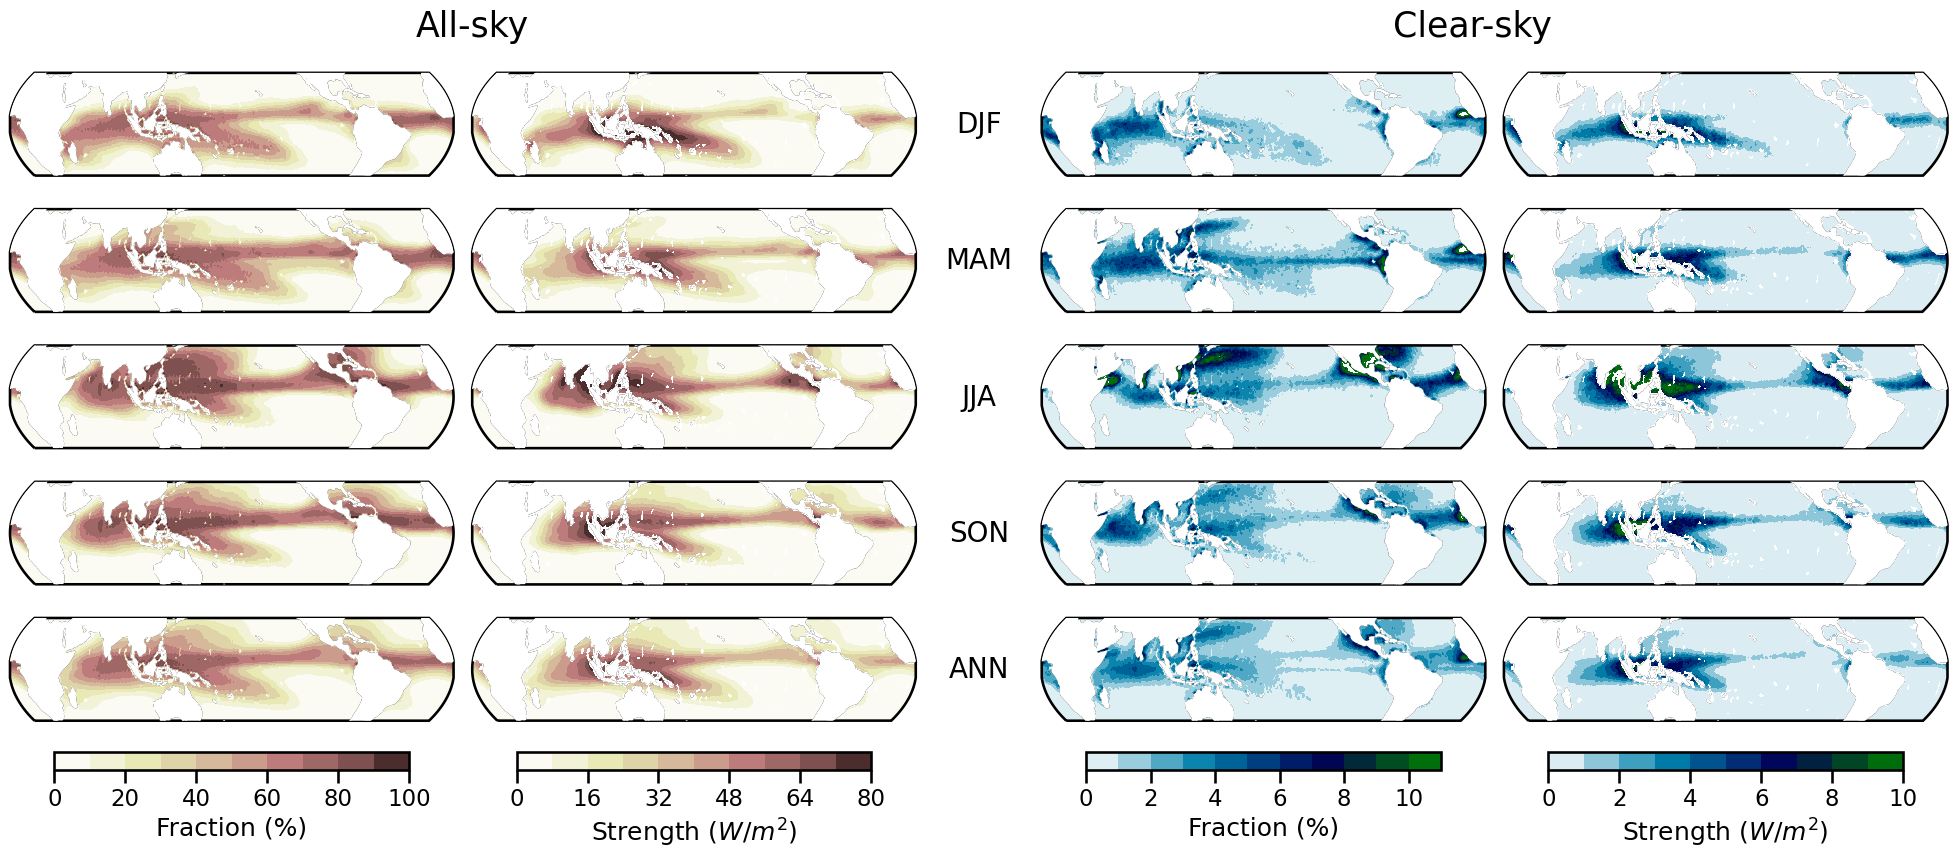

In [13]:
#Figure 4:

import matplotlib.ticker as ticker
with sns.plotting_context('talk'):

    fig = plt.figure(figsize=(25,10))
    proj=ccrs.Mollweide(central_longitude=180)
    lons = occ_all_seas.lon
    lats = occ_all_seas.lat
    all_cmap = 'pink_r'
    clr_cmap = 'ocean_r'
    gs = gridspec.GridSpec(ncols=5, nrows=6, hspace = 0.0, wspace = 0.05, height_ratios=[1,1,1,1,1,0.43], width_ratios=[1,1,0.2,1,1], figure=fig)

    ax5 = fig.add_subplot(gs[4,0], projection=proj)
    im=plt.contourf(lons,lats,occ_all_ann,10,transform=ccrs.PlateCarree(),cmap=all_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()

    ax1 = fig.add_subplot(gs[0,0], projection=proj)
    plt.contourf(lons,lats,occ_all_seas.sel(season='DJF'),im.levels,transform=ccrs.PlateCarree(),cmap=all_cmap)
    #im = ax1.pcolormesh(lons,lats,occ_all_seas.sel(season='DJF'), transform=ccrs.PlateCarree(), cmap=all_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=5)
    plt.gca().coastlines()

    #plt.subplot(445, projection=proj)
    ax2 = fig.add_subplot(gs[1,0], projection=proj)
    plt.contourf(lons,lats,occ_all_seas.sel(season='MAM'),im.levels,transform=ccrs.PlateCarree(),cmap=all_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()

    #plt.subplot(449, projection=proj)
    ax3 = fig.add_subplot(gs[2,0], projection=proj)
    plt.contourf(lons,lats,occ_all_seas.sel(season='JJA'),im.levels,transform=ccrs.PlateCarree(),cmap=all_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()

    #ax4=plt.subplot(4,4,13, projection=proj)
    ax4 = fig.add_subplot(gs[3,0], projection=proj)
    plt.contourf(lons,lats,occ_all_seas.sel(season='SON'),im.levels,transform=ccrs.PlateCarree(),cmap=all_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()

    ax6 = fig.add_subplot(gs[5,0], projection=proj)
    plt.colorbar(im,ax=ax6, location='bottom',label='Fraction (%)',fraction=0.75,shrink=0.8)
    fig.delaxes(ax6)


    ax11 = fig.add_subplot(gs[4,1], projection=proj)
    im2=plt.contourf(lons,lats,str_all_ann,10,transform=ccrs.PlateCarree(),cmap=all_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()

    ax7 = fig.add_subplot(gs[0,1], projection=proj)
    im2=plt.contourf(lons,lats,str_all_seas.sel(season='DJF'),im2.levels,transform=ccrs.PlateCarree(),cmap=all_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()

    #plt.subplot(446, projection=proj)
    ax8 = fig.add_subplot(gs[1,1], projection=proj)
    plt.contourf(lons,lats,str_all_seas.sel(season='MAM'),im2.levels,transform=ccrs.PlateCarree(),cmap=all_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()

    #plt.subplot(4,4,10, projection=proj)
    ax9 = fig.add_subplot(gs[2,1], projection=proj)
    plt.contourf(lons,lats,str_all_seas.sel(season='JJA'),im2.levels,transform=ccrs.PlateCarree(),cmap=all_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()

    #ax5=plt.subplot(4,4,14, projection=proj)
    ax10 = fig.add_subplot(gs[3,1], projection=proj)
    plt.contourf(lons,lats,str_all_seas.sel(season='SON'),im2.levels,transform=ccrs.PlateCarree(),cmap=all_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()

    ax12 = fig.add_subplot(gs[5,1], projection=proj)
    plt.colorbar(im2,ax=ax12, location='bottom',label='Strength ($W/m^2$)',fraction=0.75,shrink=0.8)
    fig.delaxes(ax12)


    ax16 = fig.add_subplot(gs[4,3], projection=proj)
    im3=plt.contourf(lons,lats,occ_clr_ann,10,transform=ccrs.PlateCarree(),cmap=clr_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()

    ax13 = fig.add_subplot(gs[0,3], projection=proj)
    im3=plt.contourf(lons,lats,occ_clr_seas.sel(season='DJF'),im3.levels,transform=ccrs.PlateCarree(),cmap=clr_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()

    #plt.subplot(447, projection=proj)
    ax14 = fig.add_subplot(gs[1,3], projection=proj)
    plt.contourf(lons,lats,occ_clr_seas.sel(season='MAM'),im3.levels,transform=ccrs.PlateCarree(),cmap=clr_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()

    #plt.subplot(4,4,11, projection=proj)
    ax15 = fig.add_subplot(gs[2,3], projection=proj)
    plt.contourf(lons,lats,occ_clr_seas.sel(season='JJA'),im3.levels,transform=ccrs.PlateCarree(),cmap=clr_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()

    #ax6=plt.subplot(4,4,15, projection=proj)
    ax15 = fig.add_subplot(gs[3,3], projection=proj)
    plt.contourf(lons,lats,occ_clr_seas.sel(season='SON'),im3.levels,transform=ccrs.PlateCarree(),cmap=clr_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()

    ax17 = fig.add_subplot(gs[5,3], projection=proj)
    l1=im3.levels
    plt.colorbar(im3,ax=ax17, location='bottom',label='Fraction (%)',fraction=0.75,shrink=0.8,ticks=l1[::2])
    fig.delaxes(ax17)   

    ax22 = fig.add_subplot(gs[4,4], projection=proj)
    im4=plt.contourf(lons,lats,str_clr_ann,10,transform=ccrs.PlateCarree(),cmap=clr_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()

    ax18 = fig.add_subplot(gs[0,4], projection=proj)
    im4=plt.contourf(lons,lats,str_clr_seas.sel(season='DJF'),im4.levels,transform=ccrs.PlateCarree(),cmap=clr_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()

    #plt.subplot(448, projection=proj)
    ax19 = fig.add_subplot(gs[1,4], projection=proj)
    plt.contourf(lons,lats,str_clr_seas.sel(season='MAM'),im4.levels,transform=ccrs.PlateCarree(),cmap=clr_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()

    #plt.subplot(4,4,12, projection=proj)
    ax20 = fig.add_subplot(gs[2,4], projection=proj)
    plt.contourf(lons,lats,str_clr_seas.sel(season='JJA'),im4.levels,transform=ccrs.PlateCarree(),cmap=clr_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()

    #ax7=plt.subplot(4,4,16, projection=proj)
    ax21 = fig.add_subplot(gs[3,4], projection=proj)
    plt.contourf(lons,lats,str_clr_seas.sel(season='SON'),im4.levels,transform=ccrs.PlateCarree(),cmap=clr_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()

    ax23 = fig.add_subplot(gs[5,4], projection=proj)
    l2 = im4.levels
    plt.colorbar(im4,ax=ax23, location='bottom',label='Strength ($W/m^2$)',fraction=0.75,shrink=0.8, ticks=l2[::2])
    fig.delaxes(ax23)

#fig.tight_layout()
fig.subplots_adjust(top=0.85)  
plt.figtext(0.31,0.88,"All-sky", va="center", ha="center", size=25)
plt.figtext(0.71,0.88,"Clear-sky", va="center", ha="center", size=25)
#add labels into center column:
labels = ['DJF','MAM','JJA','SON','ANN']
for ii in range(5):
    ax_label = fig.add_subplot(gs[ii,2])
    ax_label.text(0.5,0.5,labels[ii], horizontalalignment='center', verticalalignment='center', transform=ax_label.transAxes, fontsize=20)
    ax_label.set_axis_off()


In [ ]:
# WARNING: cell takes a long time to run, the processed trend timeseries data can be uploaded below.

vars = ['str_clr','str_all', 'occ_all','occ_clr']

for var in vars:
    trends = np.zeros((70,360))
    ts = SGE_ts['SGE_'+var].where(SGE_ts['airs_flag']==0).sel(time=slice('2003', '2022')).resample(time='M', skipna=True).mean()

    for ii in np.arange(70):
        for jj in np.arange(360):
            ts_mm = ts[:,ii,jj].to_dataframe()
            ts_mm.index = pd.to_datetime(ts_mm.index)
            sm = ts_mm.groupby([ts_mm.index.day, ts_mm.index.month]).transform('mean')
            ts_ds = (ts_mm - sm).reset_index() #remove seasonal mean
            idx = np.isfinite(ts_ds['SGE_'+var])
            if any(idx):
                t = np.arange(np.size(ts_ds['SGE_'+var]))
                lin_trend = np.polyfit(t[idx], ts_ds['SGE_'+var][idx], 1) #calculate linear trend through de-seasonalized timeseries
                trends[ii,jj] = lin_trend[0]
    
    np.savetxt('SGE_'+var+'_trends3.txt',trends)

In [16]:
#get trend already calculate from above cell.
trends_occ_all = np.loadtxt('SGE_occ_all_trends3.txt')
trends_str_all = np.loadtxt('SGE_str_all_trends3.txt')
trends_occ_clr = np.loadtxt('SGE_occ_clr_trends3.txt')
trends_str_clr = np.loadtxt('SGE_str_clr_trends3.txt')

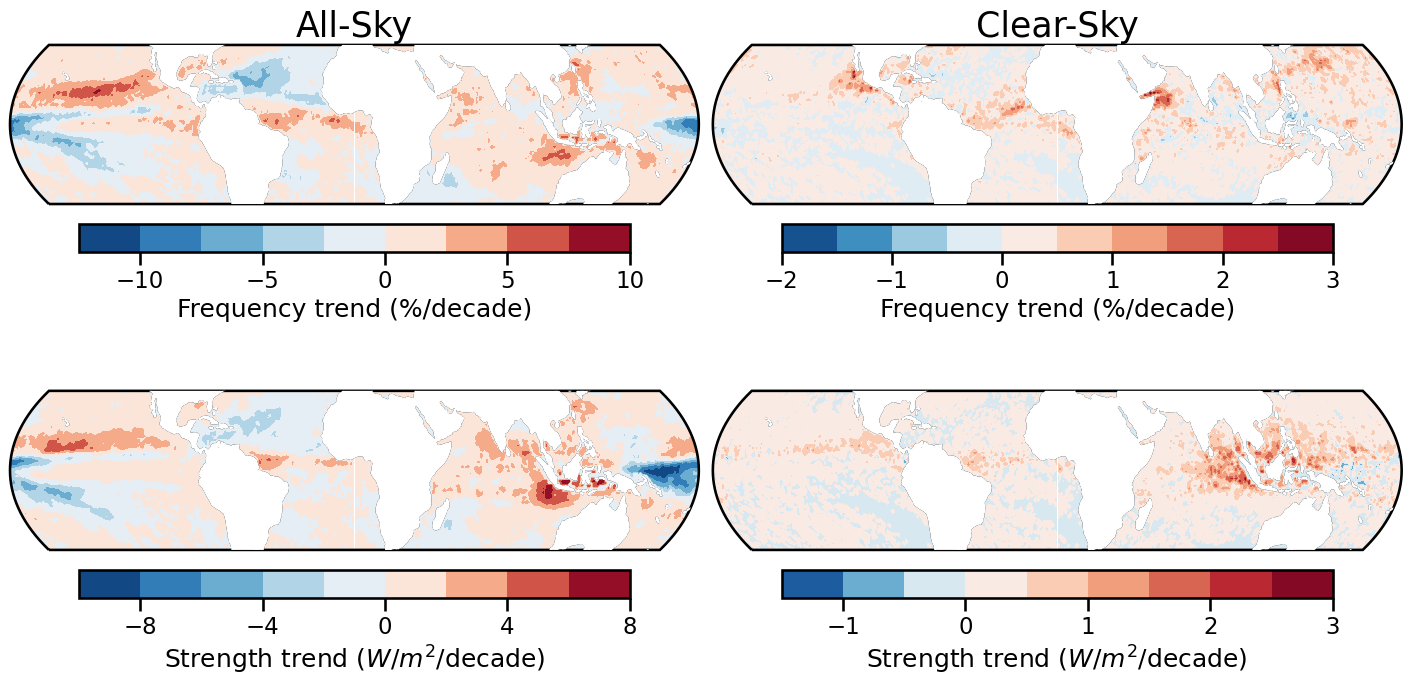

In [17]:
#Figure 5:

with sns.plotting_context('talk'):
    from matplotlib.colors import TwoSlopeNorm
    proj = ccrs.Mollweide()
    fig, axs = plt.subplots(2, 2, sharex=True, constrained_layout=True, figsize=(14,7),  subplot_kw={'projection': proj})
    tnd_cmap = 'RdBu_r'
    lats=SGE_ts.lat
    lons=SGE_ts.lon
     
    m0=axs[0,0].contourf(lons,lats,trends_occ_all*12000,8,transform=ccrs.PlateCarree(),cmap=tnd_cmap,norm=TwoSlopeNorm(vcenter=0))
    cb0=plt.colorbar(m0, ax=axs[0,0], location='bottom',fraction=0.75,shrink=0.8,label='Frequency trend (%/decade)')
    cb0.set_ticks([-10.0,-5.0,0.0,5.0,10.0])
    axs[0,0].add_feature(cartopy.feature.LAND, color='white',zorder=10)
    axs[0,0].coastlines()
    axs[0,0].set_title('All-Sky',fontsize=25)

    m2=axs[1,0].contourf(lons,lats,trends_str_all*120,8,transform=ccrs.PlateCarree(),cmap=tnd_cmap,norm=TwoSlopeNorm(vcenter=0))
    cb1=plt.colorbar(m2,ax=axs[1,0],location='bottom',fraction=0.75,shrink=0.8, label='Strength trend ($W/m^2/$decade)')
    cb1.set_ticks([-8.0,-4.0,0.0,4.0,8.0])
    axs[1,0].add_feature(cartopy.feature.LAND, color='white',zorder=10)
    axs[1,0].coastlines()

    m1=axs[0,1].contourf(lons,lats,trends_occ_clr*12000,8,transform=ccrs.PlateCarree(),cmap=tnd_cmap,norm=TwoSlopeNorm(vcenter=0))
    plt.colorbar(m1,ax=axs[0,1],location='bottom',fraction=0.75,shrink=0.8, label='Frequency trend (%/decade)')
    axs[0,1].add_feature(cartopy.feature.LAND, color='white',zorder=10)
    axs[0,1].coastlines()
    axs[0,1].set_title('Clear-Sky',fontsize=25)

    m3=axs[1,1].contourf(lons,lats,trends_str_clr*120,8,transform=ccrs.PlateCarree(),cmap=tnd_cmap,norm=TwoSlopeNorm(vcenter=0))
    cb3=plt.colorbar(m3,ax=axs[1,1],location='bottom',fraction=0.75,shrink=0.8, label='Strength trend ($W/m^2/$decade)')
    cb3.set_ticks([-1.0,0.0,1.0,2.0,3.0])
    axs[1,1].add_feature(cartopy.feature.LAND, color='white',zorder=10)
    axs[1,1].coastlines()
 
    
